# PPO agent using stable-baselines3

In this notebook, we will look at policy optimization using PPO. We will not be writing our own algorithms. Rather, we will use a fork of [OpenAI Baselines](https://github.com/openai/baselines). The version we will use is still stable-baselines3 : https://github.com/DLR-RM/stable-baselines3


The code below follows the [getting started tutorial](https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/sb3/stable_baselines_getting_started.ipynb) that comes with this library. 

#### Running in Colab/Kaggle

If you are running this on Colab, please uncomment below cells and run this to install required dependencies.

In [ ]:
## Uncomment and execute this cell to install all the the dependencies if running in Google Colab

# !apt-get update && apt-get install swig cmake ffmpeg freeglut3-dev xvfb
# !pip install box2d-py
# !pip install "stable-baselines3[extra]>=2.1"
# !pip install "huggingface_sb3>=3.0"

# !pip install git+https://github.com/DLR-RM/rl-baselines3-zoo@update/hf
# !git clone https://github.com/DLR-RM/rl-baselines3-zoo
# %cd rl-baselines3-zoo/
# !pip install -r requirements.txt
# %cd ..


#### Imports

In [10]:
import gymnasium as gym
import random
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from IPython.display import HTML, clear_output
from base64 import b64encode

%matplotlib inline

### Environment - CartPole 

We can use the setup here to run on any environment which has state as a single vector and actions are discrete. We will build it on Cart Pole and they try to run this on many other environments like Atari games and others.

In [6]:
def make_env(env_name):
    env = gym.make(env_name, render_mode="rgb_array")
    return env

state shape:(4,)
Number of Actions:2


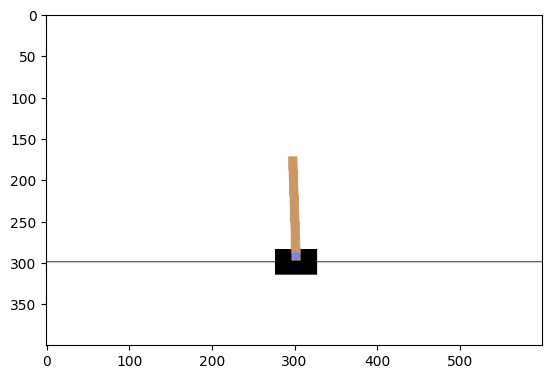

In [7]:
env_name = 'CartPole-v1'
seed=123

env = make_env(env_name)
env.reset(seed=seed)
plt.imshow(env.render())
state_shape, n_actions = env.observation_space.shape, env.action_space.n
state_dim = state_shape[0]
print(f"state shape:{state_shape}\nNumber of Actions:{n_actions}")

### Create model using `MlpPolicy` from SB3 library 

In [8]:
model = PPO(MlpPolicy, env, verbose=0)

### Untrained Agent

In [11]:
mean_reward, std_reward = evaluate_policy(Monitor(model), env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

/home/nsanghi/sandbox/apress/drl-2ed/venv39/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.predict to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.predict` for environment variables or `env.get_wrapper_attr('predict')` that will search the reminding wrappers.
  logger.warn(


mean_reward:9.47 +/- 0.68


### Train the Agent

In [12]:
# Train the agent for 30000 steps
model.learn(total_timesteps=30000)

### Evaluate Trained Agent

In [13]:
# Evaluate the trained agent
mean_reward, std_reward = evaluate_policy(Monitor(model), env, n_eval_episodes=100)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:500.00 +/- 0.00


### Trained Agent Video

In [22]:
# Helper function to record videos
def record_video(env_id, video_folder, video_length, agent):

    vec_env = DummyVecEnv([lambda: gym.make(env_id, render_mode="rgb_array")])
    # Record the video starting at the first step
    vec_env = VecVideoRecorder(vec_env, video_folder,
                           record_video_trigger=lambda x: x == 0, video_length=video_length,
                           name_prefix=f"{type(agent).__name__}-{env_id}")

    obs = vec_env.reset()
    for _ in range(video_length + 1):
        action, _ = model.predict(obs)
        obs, _, _, _ = vec_env.step(action)
    # video filename
    file_path = "./"+video_folder+vec_env.video_recorder.path.split("/")[-1]
    # Save the video
    vec_env.close()
    return file_path

def play_video(file_path):
    mp4 = open(file_path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML("""
        <video width=400 controls>
              <source src="%s" type="video/mp4">
        </video>
        """ % data_url)

In [23]:
video_folder = "logs/8_c/"
video_length = 500

video_file = record_video(env_name, video_folder, video_length, model)

play_video(video_file)

Saving video to /home/nsanghi/sandbox/apress/drl-2ed/chapter8/logs/8_c/PPO-CartPole-v1-step-0-to-step-500.mp4
Moviepy - Building video /home/nsanghi/sandbox/apress/drl-2ed/chapter8/logs/8_c/PPO-CartPole-v1-step-0-to-step-500.mp4.
Moviepy - Writing video /home/nsanghi/sandbox/apress/drl-2ed/chapter8/logs/8_c/PPO-CartPole-v1-step-0-to-step-500.mp4



Moviepy - Done !
Moviepy - video ready /home/nsanghi/sandbox/apress/drl-2ed/chapter8/logs/8_c/PPO-CartPole-v1-step-0-to-step-500.mp4


### Pushing to Huggingface
The model really looks cool. It has trained very well under PPO using the state of the art implementation. We must share it with others. Here is the code from previous chapters to push it to HuggingFace hub.

In [24]:
from huggingface_sb3 import load_from_hub, package_to_hub, push_to_hub
from huggingface_hub import notebook_login # To log to our Hugging Face account to be able to upload models to the Hub.

notebook_login()
!git config --global credential.helper store

**IMPORTANT**
Some users have reported facing following error while running the `package_to_hub` upload function. 

```
"Token is required (write-access action) but no token found. You need to provide a token or be logged in to Hugging Face with `huggingface-cli login` or `huggingface_hub.login`. See https://huggingface.co/settings/tokens."
```

In such a case the following command will help you over come the issue

```
import huggingface_hub

huggingface_hub.login(token= <YOUR_HF_TOKEN>,
                     write_permission = True,
                    add_to_git_credential = True)
					
```

Another alternative is to use following command from command shell where the `venv` or `conda` environment for this repository has been activated and then follow the instructions to set the HuggingFace token.

```
huggingface-cli login

```

In [25]:
eval_env = DummyVecEnv([lambda: gym.make(env_name, render_mode="rgb_array")])
obs = eval_env.reset()

# method save, evaluate, generate a model card and record a replay video of your agent before pushing the repo to the hub

# Please note repo_id is of the form <huggingface_id>/<name of repo>
# you will need to change this to "<your_huggingface_id>/ppo-cart-pole-v1"

package_to_hub(model=model, # Our trained model
               model_name= "PPO-" + env_name, # The name of our trained model
               model_architecture="PPO", # The model architecture we used: in our case PPO
               env_id=env_name, # Name of the environment
               eval_env=eval_env, # Evaluation Environment
               repo_id="nsanghi/ppo-cart-pole-sb3", # id of the model repository from the Hugging Face Hub (repo_id = {organization}/{repo_name}
               commit_message="Push to Hub")

ℹ This function will save, evaluate, generate a video of your agent,
create a model card and push everything to the hub. It might take up to 1min.
This is a work in progress: if you encounter a bug, please open an issue.


/home/nsanghi/sandbox/apress/drl-2ed/venv39/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Saving video to /tmp/tmp7glebltb/-step-0-to-step-1000.mp4
Moviepy - Building video /tmp/tmp7glebltb/-step-0-to-step-1000.mp4.
Moviepy - Writing video /tmp/tmp7glebltb/-step-0-to-step-1000.mp4



Moviepy - Done !
Moviepy - video ready /tmp/tmp7glebltb/-step-0-to-step-1000.mp4


ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

ℹ Pushing repo nsanghi/ppo-cart-pole-sb3 to the Hugging Face Hub


pytorch_variables.pth:   0%|          | 0.00/864 [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

policy.pth:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

policy.optimizer.pth:   0%|          | 0.00/82.9k [00:00<?, ?B/s]

PPO-CartPole-v1.zip:   0%|          | 0.00/139k [00:00<?, ?B/s]

ℹ Your model is pushed to the Hub. You can view your model here:
https://huggingface.co/nsanghi/ppo-cart-pole-sb3/tree/main/


'https://huggingface.co/nsanghi/ppo-cart-pole-sb3/tree/main/'